In [266]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import pennylane as qml
import scipy as sp
from autograd import grad, jacobian

# Pennylane numpy
from pennylane import numpy as pnp 

In [267]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=1)

In [268]:
def hamiltonian(paras):
    coeff_x = paras[0]
    coeff_y = paras[1]
    
    coeffs = [coeff_x, coeff_y, 1]
    rot = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]
    
    return qml.Hamiltonian(coeffs = coeffs, observables = rot)

$$
H = 
coeff_{x} \cdot(X_0) + coeff_{y} \cdot(Y_0) + 1 \cdot(Z_0)
$$

In [269]:
@qml.qnode(dev)
def circuit(paras):
    coeff_in = np.zeros(2)
    coeff_in = paras[:2] 
    dt = paras[2]
    
    get_hamiltonian = hamiltonian(coeff_in)
    qml.ApproxTimeEvolution(get_hamiltonian, dt, 1)
    
    return qml.density_matrix(wires=0)

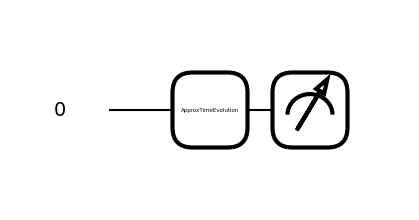

In [270]:
null = 1,1,1
fig, ax = qml.draw_mpl(circuit)(null)

In [271]:
@qml.qnode(dev)
def hadamard():
    qml.Hadamard(wires=0)
    
    return qml.density_matrix(wires=0)

In [272]:
hadamard().numpy()

array([[0.5+0.j, 0.5+0.j],
       [0.5+0.j, 0.5+0.j]])

In [273]:
paras_init = 1, 1, 1   # coeff_x, coeff_y, dt

circuit(paras_init)

array([[0.58658909-5.55111512e-17j, 0.49214615-1.71609834e-02j],
       [0.49214615+1.71609834e-02j, 0.41341091+0.00000000e+00j]])

In [274]:
def fidelity(rho_1, rho_2):
    stage_1 = sp.linalg.sqrtm(sp.linalg.sqrtm(rho_1) @ rho_2 @ sp.linalg.sqrtm(rho_1))
    
    return np.trace(stage_1)

In [275]:
def cost_function(paras):
    rho_1 = circuit(paras)
    rho_2 = hadamard().numpy()
    
    cal_fidelity = fidelity(rho_1, rho_2)
    
    return -cal_fidelity

In [276]:
initial_paras = 1,2,3 # coeff_x, coeff_y, dt

constraints = [
    # coeff_x
    (-float('inf'), float('inf')),
    # coeff_y
    (-float('inf'), float('inf')),
    # dt
    (-float('inf'), float('inf')),
]

result = sp.optimize.minimize(
    fun = cost_function, 
    x0 = initial_paras,
    method = 'L-BFGS-B',
    bounds = constraints,
    
    tol = 1e-20,
    options={
        'ftol': 1e-20, 
        'gtol': 1e-20
        }
    )

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_lbfgsb_py.py:352: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,


In [277]:
print('[optimized_fidelity] =', -result.fun)
print()
print('[coeff_x, coeff_y] =', result.x[0], result.x[1])
print('[dt] =', result.x[2])

[optimized_fidelity] = (0.9997156800695326-2.0468097805974366e-10j)

[coeff_x, coeff_y] = 0.486746939904152 2.740731903661214
[dt] = 3.1585145565274337
